In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.formula.api import ols
from scipy import stats
import math
from sklearn.linear_model import LinearRegression

In [9]:
taxi = pd.read_csv('taxi_data.csv')
taxi = taxi.drop('Unnamed: 0', axis=1)
taxi.weather_summary.unique()

array(['Overcast', 'Mostly Cloudy', 'Clear', 'Partly Cloudy',
       'Light Rain', 'Rain', 'Heavy Rain', nan, 'Humid and Overcast'],
      dtype=object)

In [12]:
taxi = taxi.dropna()
taxi.info()
taxi.weather_summary.unique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245054 entries, 0 to 249720
Data columns (total 16 columns):
tpep_pickup_datetime     245054 non-null object
tpep_dropoff_datetime    245054 non-null object
passenger_count          245054 non-null int64
trip_distance            245054 non-null float64
RatecodeID               245054 non-null int64
PULocationID             245054 non-null int64
DOLocationID             245054 non-null int64
payment_type             245054 non-null int64
fare_amount              245054 non-null float64
tip_amount               245054 non-null float64
tolls_amount             245054 non-null float64
total_amount             245054 non-null float64
trip_time                245054 non-null object
rounded_DOtime           245054 non-null object
apparentTemperature      245054 non-null float64
weather_summary          245054 non-null object
dtypes: float64(6), int64(5), object(5)
memory usage: 31.8+ MB


array(['Overcast', 'Mostly Cloudy', 'Clear', 'Partly Cloudy',
       'Light Rain', 'Rain', 'Heavy Rain', 'Humid and Overcast'],
      dtype=object)

In [45]:
taxi.head()
taxi_test = taxi.sample(50000).reset_index(drop=True)
taxi_test.shape

(50000, 16)

In [46]:
taxi_test = taxi_test.rename(columns={'tpep_pickup_datetime':'pickup_dt', 'tpep_dropoff_datetime':'dropoff_dt'})
taxi_test = taxi_test.drop('rounded_DOtime', axis=1)
taxi_test.head()

,pickup_dt,dropoff_dt,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,tolls_amount,total_amount,trip_time,apparentTemperature,weather_summary
0,2018-10-25 10:01:35,2018-10-25 10:13:57,1,1.70,1,262,229,2,9.5,0.00,0.00,10.30,0 days 00:12:22.000000000,40.91,Clear
1,2018-10-05 20:17:42,2018-10-05 20:37:16,1,3.23,1,249,87,1,15.5,3.36,0.00,20.16,0 days 00:19:34.000000000,63.37,Mostly Cloudy
2,2018-10-15 09:24:44,2018-10-15 09:42:57,1,2.66,1,100,236,2,13.5,0.00,0.00,14.30,0 days 00:18:13.000000000,59.20,Overcast
3,2018-10-25 16:10:09,2018-10-25 16:18:11,0,0.90,1,264,264,1,7.0,1.00,0.00,9.80,0 days 00:08:02.000000000,51.01,Clear
4,2018-10-10 18:56:38,2018-10-10 19:51:10,1,18.37,2,132,48,1,52.0,12.61,5.76,75.67,0 days 00:54:32.000000000,74.28,Mostly Cloudy


In [47]:
taxi_test.pickup_dt = [pd.to_datetime(x) for x in taxi_test.pickup_dt]
taxi_test.dropoff_dt = [pd.to_datetime(x) for x in taxi_test.dropoff_dt]

In [29]:
taxi_test.trip_time[0]

'00:06:03.000000000'

In [48]:
taxi_test.trip_time = taxi_test.trip_time.str.replace('0 days ', '')

In [50]:
taxi_test.trip_time = [pd.to_datetime(x) for x in taxi_test.trip_time]
taxi_test.trip_time = [val.time() for val in taxi_test.trip_time]


In [36]:
type(taxi_test.trip_time[0])

datetime.time

In [25]:
taxi_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
pickup_dt              50000 non-null datetime64[ns]
dropoff_dt             50000 non-null datetime64[ns]
passenger_count        50000 non-null int64
trip_distance          50000 non-null float64
RatecodeID             50000 non-null int64
PULocationID           50000 non-null int64
DOLocationID           50000 non-null int64
payment_type           50000 non-null int64
fare_amount            50000 non-null float64
tip_amount             50000 non-null float64
tolls_amount           50000 non-null float64
total_amount           50000 non-null float64
trip_time              50000 non-null object
apparentTemperature    50000 non-null float64
weather_summary        50000 non-null object
dtypes: datetime64[ns](2), float64(6), int64(5), object(2)
memory usage: 5.7+ MB


In [51]:
import datetime
taxi_test.dropoff_dt[0].weekday()
taxi_test['day_of_week'] = [x.weekday() for x in taxi_test.dropoff_dt]
taxi_test.head()

,pickup_dt,dropoff_dt,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,tolls_amount,total_amount,trip_time,apparentTemperature,weather_summary,day_of_week
0,2018-10-25 10:01:35,2018-10-25 10:13:57,1,1.70,1,262,229,2,9.5,0.00,0.00,10.30,00:12:22,40.91,Clear,3
1,2018-10-05 20:17:42,2018-10-05 20:37:16,1,3.23,1,249,87,1,15.5,3.36,0.00,20.16,00:19:34,63.37,Mostly Cloudy,4
2,2018-10-15 09:24:44,2018-10-15 09:42:57,1,2.66,1,100,236,2,13.5,0.00,0.00,14.30,00:18:13,59.20,Overcast,0
3,2018-10-25 16:10:09,2018-10-25 16:18:11,0,0.90,1,264,264,1,7.0,1.00,0.00,9.80,00:08:02,51.01,Clear,3
4,2018-10-10 18:56:38,2018-10-10 19:51:10,1,18.37,2,132,48,1,52.0,12.61,5.76,75.67,00:54:32,74.28,Mostly Cloudy,2


In [65]:
from datetime import timedelta
(taxi_test.dropoff_dt[0] - taxi_test.pickup_dt[0]).total_seconds()

742.0

In [67]:
taxi_test.trip_time = [(taxi_test.dropoff_dt[i] - taxi_test.pickup_dt[i]).total_seconds()/60 for i in range(len(taxi_test))]
taxi_test.head()
taxi_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
pickup_dt              50000 non-null datetime64[ns]
dropoff_dt             50000 non-null datetime64[ns]
passenger_count        50000 non-null int64
trip_distance          50000 non-null float64
RatecodeID             50000 non-null int64
PULocationID           50000 non-null int64
DOLocationID           50000 non-null int64
payment_type           50000 non-null int64
fare_amount            50000 non-null float64
tip_amount             50000 non-null float64
tolls_amount           50000 non-null float64
total_amount           50000 non-null float64
trip_time              50000 non-null float64
apparentTemperature    50000 non-null float64
weather_summary        50000 non-null object
day_of_week            50000 non-null int64
dtypes: datetime64[ns](2), float64(7), int64(6), object(1)
memory usage: 6.1+ MB


In [82]:
taxi_test.dropoff_dt[0].time() > datetime.time(10,0,0)
taxi_test['time_of_day'] = ''
taxi_test.head()
taxi_test.to_csv('taxi_test.csv')

In [83]:
weather_dummies = pd.get_dummies(taxi_test.weather_summary, prefix='weather_summary')
taxi_test = pd.concat([taxi_test, weather_dummies], axis=1)
taxi_test.head()

,pickup_dt,dropoff_dt,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,...,day_of_week,time_of_day,weather_summary_Clear,weather_summary_Heavy Rain,weather_summary_Humid and Overcast,weather_summary_Light Rain,weather_summary_Mostly Cloudy,weather_summary_Overcast,weather_summary_Partly Cloudy,weather_summary_Rain
0,2018-10-25 10:01:35,2018-10-25 10:13:57,1,1.70,1,262,229,2,9.5,0.00,...,3,,1,0,0,0,0,0,0,0
1,2018-10-05 20:17:42,2018-10-05 20:37:16,1,3.23,1,249,87,1,15.5,3.36,...,4,,0,0,0,0,1,0,0,0
2,2018-10-15 09:24:44,2018-10-15 09:42:57,1,2.66,1,100,236,2,13.5,0.00,...,0,,0,0,0,0,0,1,0,0
3,2018-10-25 16:10:09,2018-10-25 16:18:11,0,0.90,1,264,264,1,7.0,1.00,...,3,,1,0,0,0,0,0,0,0
4,2018-10-10 18:56:38,2018-10-10 19:51:10,1,18.37,2,132,48,1,52.0,12.61,...,2,,0,0,0,0,1,0,0,0


In [84]:
taxi_test1 = taxi_test[taxi_test.passenger_count!=0]

In [91]:
taxi_test.passenger_count = taxi_test.passenger_count.replace(0,1)

In [92]:
taxi_test[taxi_test.passenger_count == 0]

,pickup_dt,dropoff_dt,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,...,day_of_week,time_of_day,weather_summary_Clear,weather_summary_Heavy Rain,weather_summary_Humid and Overcast,weather_summary_Light Rain,weather_summary_Mostly Cloudy,weather_summary_Overcast,weather_summary_Partly Cloudy,weather_summary_Rain


In [93]:
passenger_dummies = pd.get_dummies(taxi_test.passenger_count, prefix='passenger_count')
taxi_test = pd.concat([taxi_test, passenger_dummies], axis=1)
taxi_test.head()

,pickup_dt,dropoff_dt,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,...,weather_summary_Mostly Cloudy,weather_summary_Overcast,weather_summary_Partly Cloudy,weather_summary_Rain,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6
0,2018-10-25 10:01:35,2018-10-25 10:13:57,1,1.70,1,262,229,2,9.5,0.00,...,0,0,0,0,1,0,0,0,0,0
1,2018-10-05 20:17:42,2018-10-05 20:37:16,1,3.23,1,249,87,1,15.5,3.36,...,1,0,0,0,1,0,0,0,0,0
2,2018-10-15 09:24:44,2018-10-15 09:42:57,1,2.66,1,100,236,2,13.5,0.00,...,0,1,0,0,1,0,0,0,0,0
3,2018-10-25 16:10:09,2018-10-25 16:18:11,1,0.90,1,264,264,1,7.0,1.00,...,0,0,0,0,1,0,0,0,0,0
4,2018-10-10 18:56:38,2018-10-10 19:51:10,1,18.37,2,132,48,1,52.0,12.61,...,1,0,0,0,1,0,0,0,0,0


In [94]:
rate_code_dummies = pd.get_dummies(taxi_test.RatecodeID, prefix='RatecodeID')
taxi_test = pd.concat([taxi_test, rate_code_dummies], axis=1)
taxi_test.head()

,pickup_dt,dropoff_dt,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,...,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,RatecodeID_1,RatecodeID_2,RatecodeID_3,RatecodeID_4,RatecodeID_5,RatecodeID_99
0,2018-10-25 10:01:35,2018-10-25 10:13:57,1,1.70,1,262,229,2,9.5,0.00,...,0,0,0,0,1,0,0,0,0,0
1,2018-10-05 20:17:42,2018-10-05 20:37:16,1,3.23,1,249,87,1,15.5,3.36,...,0,0,0,0,1,0,0,0,0,0
2,2018-10-15 09:24:44,2018-10-15 09:42:57,1,2.66,1,100,236,2,13.5,0.00,...,0,0,0,0,1,0,0,0,0,0
3,2018-10-25 16:10:09,2018-10-25 16:18:11,1,0.90,1,264,264,1,7.0,1.00,...,0,0,0,0,1,0,0,0,0,0
4,2018-10-10 18:56:38,2018-10-10 19:51:10,1,18.37,2,132,48,1,52.0,12.61,...,0,0,0,0,0,1,0,0,0,0


In [97]:
taxi_test[taxi_test.trip_distance == 0.00]
taxi_test = taxi_test[taxi_test.trip_distance != 0.00]

In [99]:
taxi_test = taxi_test[taxi_test.RatecodeID != 99]
taxi_test.drop('RatecodeID_99', axis=1, inplace=True)

In [108]:
taxi_test.reset_index(drop=True)
taxi_test.shape

(49642, 36)

In [109]:
taxi_test.head()

,pickup_dt,dropoff_dt,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,...,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,RatecodeID_1,RatecodeID_2,RatecodeID_3,RatecodeID_4,RatecodeID_5
0,2018-10-25 10:01:35,2018-10-25 10:13:57,1,1.70,1,262,229,2,9.5,0.00,...,0,0,0,0,0,1,0,0,0,0
1,2018-10-05 20:17:42,2018-10-05 20:37:16,1,3.23,1,249,87,1,15.5,3.36,...,0,0,0,0,0,1,0,0,0,0
2,2018-10-15 09:24:44,2018-10-15 09:42:57,1,2.66,1,100,236,2,13.5,0.00,...,0,0,0,0,0,1,0,0,0,0
3,2018-10-25 16:10:09,2018-10-25 16:18:11,1,0.90,1,264,264,1,7.0,1.00,...,0,0,0,0,0,1,0,0,0,0
4,2018-10-10 18:56:38,2018-10-10 19:51:10,1,18.37,2,132,48,1,52.0,12.61,...,0,0,0,0,0,0,1,0,0,0


In [110]:
payment_dummies = pd.get_dummies(taxi_test.payment_type, prefix='payment_type')
taxi_test = pd.concat([taxi_test, payment_dummies], axis=1)

In [112]:
day_of_week_dummies = pd.get_dummies(taxi_test.day_of_week, prefix='day_of_week')
taxi_test = pd.concat([taxi_test, day_of_week_dummies], axis=1)

In [140]:
taxi_test.columns

Index(['pickup_dt', 'dropoff_dt', 'passenger_count', 'trip_distance',
       'RatecodeID', 'PULocationID', 'DOLocationID', 'payment_type',
       'fare_amount', 'tip_amount', 'tolls_amount', 'total_amount',
       'trip_time', 'apparentTemperature', 'weather_summary', 'day_of_week',
       'time_of_day', 'weather_summary_Clear', 'weather_summary_Heavy Rain',
       'weather_summary_Humid and Overcast', 'weather_summary_Light Rain',
       'weather_summary_Mostly Cloudy', 'weather_summary_Overcast',
       'weather_summary_Partly Cloudy', 'weather_summary_Rain',
       'passenger_count_1', 'passenger_count_2', 'passenger_count_3',
       'passenger_count_4', 'passenger_count_5', 'passenger_count_6',
       'RatecodeID_1', 'RatecodeID_2', 'RatecodeID_3', 'RatecodeID_4',
       'RatecodeID_5', 'payment_type_1', 'payment_type_2', 'payment_type_3',
       'payment_type_4', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2',
       'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_we

In [141]:
taxi_testm = taxi_test.drop(['passenger_count', 'RatecodeID', 'PULocationID', 'DOLocationID',
                             'payment_type', 'weather_summary', 'day_of_week'], axis=1)

In [142]:
taxi_testm.head()

,pickup_dt,dropoff_dt,trip_distance,fare_amount,tip_amount,tolls_amount,total_amount,trip_time,apparentTemperature,time_of_day,...,payment_type_2,payment_type_3,payment_type_4,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,2018-10-25 10:01:35,2018-10-25 10:13:57,1.70,9.5,0.00,0.00,10.30,12.366667,40.91,,...,1,0,0,0,0,0,1,0,0,0
1,2018-10-05 20:17:42,2018-10-05 20:37:16,3.23,15.5,3.36,0.00,20.16,19.566667,63.37,,...,0,0,0,0,0,0,0,1,0,0
2,2018-10-15 09:24:44,2018-10-15 09:42:57,2.66,13.5,0.00,0.00,14.30,18.216667,59.20,,...,1,0,0,1,0,0,0,0,0,0
3,2018-10-25 16:10:09,2018-10-25 16:18:11,0.90,7.0,1.00,0.00,9.80,8.033333,51.01,,...,0,0,0,0,0,0,1,0,0,0
4,2018-10-10 18:56:38,2018-10-10 19:51:10,18.37,52.0,12.61,5.76,75.67,54.533333,74.28,,...,0,0,0,0,0,1,0,0,0,0


In [143]:
taxi_testm = taxi_testm.drop('total_amount', axis=1)

In [179]:
taxi_testm.corr()

,fare_amount,tip_amount,tolls_amount,trip_time,apparentTemperature,weather_summary_Clear,weather_summary_Heavy Rain,weather_summary_Humid and Overcast,weather_summary_Light Rain,weather_summary_Mostly Cloudy,...,payment_type_2,payment_type_3,payment_type_4,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
fare_amount,1.000000,0.596066,0.635037,0.170686,0.015032,0.010283,-0.004222,-0.005537,-0.014457,-0.002461,...,-0.045291,0.010175,0.007971,-0.003073,-0.008552,-0.003668,0.020406,0.016119,-0.027655,0.007101
tip_amount,0.596066,1.000000,0.470548,0.090498,0.011323,0.016652,0.000700,-0.002847,-0.009950,-0.002162,...,-0.485093,-0.047355,-0.025444,0.004794,0.002126,0.012055,0.023911,0.008548,-0.043345,-0.010091
tolls_amount,0.635037,0.470548,1.000000,0.096636,0.013733,-0.000913,-0.006267,-0.006032,-0.010209,0.006038,...,-0.039564,0.002951,-0.000928,0.015315,0.000774,-0.005660,0.006028,0.006745,-0.030525,0.007932
trip_time,0.170686,0.090498,0.096636,1.000000,0.003396,0.000884,-0.003558,-0.002278,-0.008032,0.000848,...,-0.006642,-0.002824,0.000073,-0.007338,-0.002087,0.003666,0.016611,0.008277,-0.011362,-0.008649
apparentTemperature,0.015032,0.011323,0.013733,0.003396,1.000000,-0.361474,0.039340,0.067183,-0.061102,0.184715,...,0.011988,-0.003824,-0.002464,0.065382,0.121946,0.112242,-0.013425,-0.097867,-0.098307,-0.109892
weather_summary_Clear,0.010283,0.016652,-0.000913,0.000884,-0.361474,1.000000,-0.033598,-0.029393,-0.120815,-0.396561,...,-0.016643,0.009922,0.000739,-0.184439,0.084745,0.019395,0.162036,0.133421,-0.159608,-0.068161
weather_summary_Heavy Rain,-0.004222,0.000700,-0.006267,-0.003558,0.039340,-0.033598,1.000000,-0.001961,-0.008059,-0.026451,...,0.002925,-0.002934,-0.001577,-0.018926,0.110442,-0.021176,-0.019072,-0.019281,-0.018841,-0.017613
weather_summary_Humid and Overcast,-0.005537,-0.002847,-0.006032,-0.002278,0.067183,-0.029393,-0.001961,1.000000,-0.007050,-0.023141,...,-0.003688,-0.002567,-0.001379,-0.016557,-0.017752,-0.018526,0.102800,-0.016868,-0.016483,-0.015408
weather_summary_Light Rain,-0.014457,-0.009950,-0.010209,-0.008032,-0.061102,-0.120815,-0.008059,-0.007050,1.000000,-0.095116,...,0.010568,-0.000692,0.001651,-0.062050,-0.072966,-0.068960,0.070536,-0.069331,0.273548,-0.063333
weather_summary_Mostly Cloudy,-0.002461,-0.002162,0.006038,0.000848,0.184715,-0.396561,-0.026451,-0.023141,-0.095116,1.000000,...,0.005752,-0.009351,-0.002966,-0.003518,0.007290,0.084491,-0.113732,-0.001687,-0.054943,0.079455


In [145]:
taxi_testm.drop('trip_distance', axis=1, inplace=True)

In [149]:
taxi_testm.to_csv('taxi_testm.csv')

In [182]:
f='tip_amount~tolls_amount+RatecodeID_1+RatecodeID_2+RatecodeID_3+RatecodeID_4+payment_type_1+payment_type_2+trip_time'
taxi_model = ols(f, taxi_testm).fit()
taxi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             tip_amount   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     5689.
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        17:28:45   Log-Likelihood:                -99892.
No. Observations:               49642   AIC:                         1.998e+05
Df Residuals:                   49633   BIC:                         1.999e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.2335      0.196     -1.190      0.234      -0.618       0.151
tolls_amount       0.5986      0.006     92.287      0.000       0.586       0.611
RatecodeID_1      -0.2100      0.158     -1.326      0.185      -0.520       0.100
RatecodeID_2       2.7463      0.165     16.634      0.000       2.423       3.070
RatecodeID_3       1.0108      0.263      3.846      0.000       0.496       1.526
RatecodeID_4       6.5919      0.320     20.570      0.000       5.964       7.220
payment_type_1     2.8084      0.116     24.191      0.000       2.581       3.036
payment_type_2     0.1833      0.117      1.571      0.116      -0.045       0.412
trip_time          0.0014      0.000     11.320      0.000       0.001       0.002
==============================================================================
Omnibus:                    50536.685   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         31229965.151
Skew:                           4.230   Prob(JB):                         0.00
Kurtosis:                     125.584   Cond. No.                     3.36e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.36e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [180]:
taxi_testm[taxi_testm.tip_amount == 0].shape

(16301, 38)

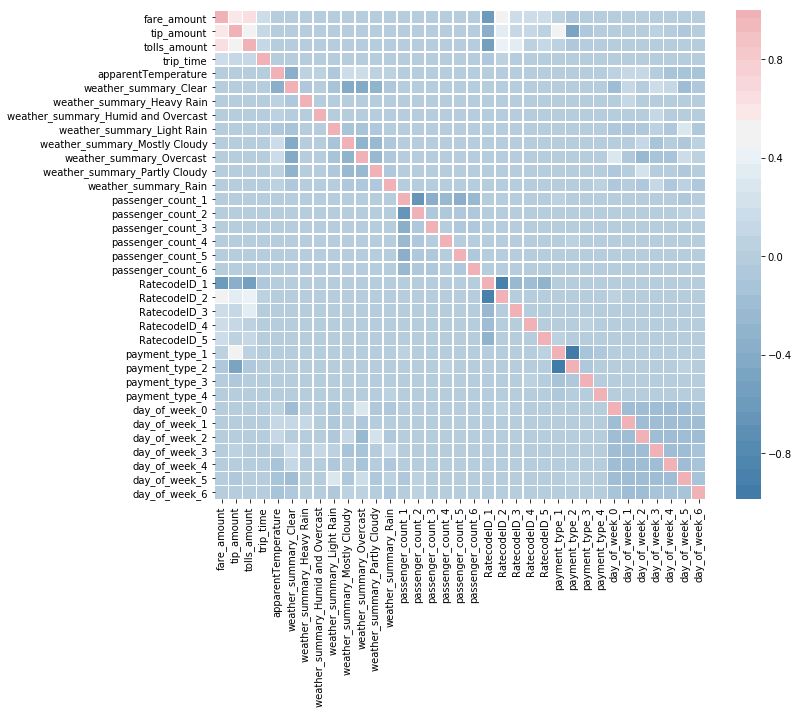

In [178]:
corr = taxi_testm.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, n=50)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=1, center=.5,
             linewidths=.5)